### PROTOTIPO

In [0]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not available
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")

import cv2
import imutils
from skimage import io, color
from sklearn.cluster import KMeans
#configuracion necesaria de pyplot para ver las imagenes en escala de grises
plt.rcParams['image.cmap'] = 'gray'
# comando de Jupyter para que las imagenes se muestren automaticamente 
%matplotlib inline

import os
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### **Procesamiento del texto TF-IDF**

##### Limpieza de datos

In [0]:
import re

def remover_num(texto):
    ## elimina algun caracter que no sea palabra
    new_text = re.sub("\W+", " ", texto)
    ## elimina números
    new_text = re.sub("\d+", " ", new_text).strip()
    return new_text

In [0]:
import unicodedata

def elimina_tildes(texto):
    new_text = ''.join((c for c in unicodedata.normalize('NFD',
                                                  texto) if unicodedata.category(c) != 'Mn'))
    return new_text

In [0]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt") ## Sentence tokenizer | divide a text

def tokens(text):
    new_text = word_tokenize(text, language="spanish")
    return new_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

def remove_repeated_characters(tokens):
  repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
  match_substitution = r'\1\2\3'
  
  def replace(old_word):
    if wordnet.synsets(old_word):
      return old_word
    new_word = repeat_pattern.sub(match_substitution, old_word)
    return replace(new_word) if new_word != old_word else new_word
    
  correct_tokens = [replace(word) for word in tokens]
  return correct_tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
import nltk.data
nltk.download('stopwords')
#stopwords.words('english')

from nltk.corpus import stopwords
def remover_stopwords_eng(text, lang='english'):
    words = text
    lang_stopwords = stopwords.words(lang)
    stopwords_removed = [w for w in words if w.lower() not in lang_stopwords]
    return stopwords_removed

def remover_stopwords_spani(text, lang='spanish'):
    words = text
    lang_stopwords = stopwords.words(lang)
    stopwords_removed = [w for w in words if w.lower() not in lang_stopwords]
    return stopwords_removed

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def join_all(text):
    new_text = " ".join(text)    
    return new_text

In [0]:
def preprocess(text):

    text = text.lower()
    #print(text)
    #print("------------------------------------------")
    text = remover_num(text)
    #print(text)
    #print("------------------------------------------")
    text = elimina_tildes(text)
    #print(text)
    #print("------------------------------------------")
    text = tokens(text)
    #print(text)
    #print("------------------------------------------")
    text = remove_repeated_characters(text)
    #print(text)
    #print("------------------------------------------")
    text = remover_stopwords_eng(text)
    #print(text)
    #print("------------------------------------------")
    text = remover_stopwords_spani(text)
    #print(text)
    #print("------------------------------------------")
    text = join_all(text)
    #print(text)

    return text

##### Extraccion de caracteristicas: TFIDF

In [0]:
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
#directorio
import joblib
filename = os.path.join(directorio,"model_tfidf")
model_tfidf = joblib.load(filename)
model_tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
def display_features(features, features_names):
  df = pd.DataFrame(data = features,
                    columns=features_names)
  return df

##### Clasificador: MLP

In [0]:
#load saved model
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
import joblib
filename = os.path.join(directorio,"model_mlp_tfidf")
clasificador_text = joblib.load(filename)
print(clasificador_text) 

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=3, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


#### **Procesamiento del Imagen - SIFT**

##### Procesamiento de la imagen


In [0]:
def Procesamiento_Img(ruta_imag):
 
    image = cv2.imread(ruta_imag)
    plt.imshow(image)
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.astype('uint8')

    return image 

##### Vectores característicos SIFT con Kmeans de 50


In [0]:
def Sift_Vector(image):
    sift = cv2.xfeatures2d.SIFT_create(200)
    k, d = sift.detectAndCompute(image, None)
    #print("Vector del Sift: "+str(len(d)))

    descriptor = d.reshape(-1,128)
    #print(descriptor.shape)

    vect_carac=np.asarray(descriptor)
    #vect_carac=np.concatenate(vect_carac, axis=0)
    #print(vect_carac.shape)
    return [k, vect_carac]   

In [0]:
#load saved model
import joblib
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
filename = os.path.join(directorio,"MODELOS_2/KMEANS MODEL","kmeans_Sift_50")
mod_km50 = joblib.load(filename)
mod_km50

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [0]:
def vector_KMeans(mod_km50, descrip):
  entra_sift_50 = []
  kma = mod_km50.predict(descrip)
  hist, bin_edges=np.histogram(kma, bins=50)
  feature_vectors=np.asarray(hist)
  vector_entradas = []
  if d.shape == 0:
    vector_entradas.append(np.zeros((50,), dtype=int))
  else:
    vector_entradas.append(feature_vectors)

  tabla_entra_sift_50 = pd.DataFrame(vector_entradas)
  return tabla_entra_sift_50

In [0]:
tabla_sift_vector = vector_KMeans(mod_km50, d)
tabla_sift_vector

0   1   2   3   4   5   6   7   8   9   10  ...  39  40  41  42  43  44  45  46  47  48  49
0   6   3   4   4   4   4   4   3   4   6   3  ...   2   7   5   4   0   1   3   4   4   2   1

[1 rows x 50 columns]

##### Escalando el vector


In [0]:
import joblib
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
filename = os.path.join(directorio,"MODELOS_2/Scaler_Sift_50")
mod_scal = joblib.load(filename)
mod_scal

StandardScaler(copy=True, with_mean=True, with_std=True)

##### Clasificador: SVM


In [0]:
#load saved model
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
filename = os.path.join(directorio,"MODELOS_2/model_svm_Sift_50")
clasificador_img = joblib.load(filename)
print(clasificador_img) 

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


#### **Procesamiento de la imagen con CNN**

In [0]:
## architecture CNN
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

## transfer learning
from keras.applications import VGG16

import cv2
from skimage import io
from keras.models import load_model

##### Cambios en la imagen


In [0]:
def Procesamiento_Img_CNN(ruta_imag):
 
    image = cv2.imread(ruta_imag)
    image = cv2.resize(image, (224,224))
    #print(image.shape)
    image = image/255.0 ## scale
    #print(image.shape)
    image = image.reshape(-1, 224, 224, 3) ## reshape

    return image 

##### Clasificador CNN


In [0]:
## load the model
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
ad = os.path.join(directorio,'MODELOS_2','VGG_ENTRADAS','model_vgg16_v2_Real.h5')
clasificador_CNN = load_model(ad)
clasificador_CNN

### **PREDICCIÓN Y CLASIFICACIÓN DE UNA PUBLICIDAD**

#### Publicación 1: popular
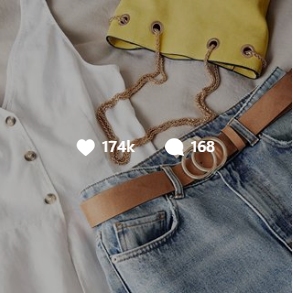
---
https://www.instagram.com/p/B9MYBZVhO0U/?utm_source=ig_web_copy_link
---
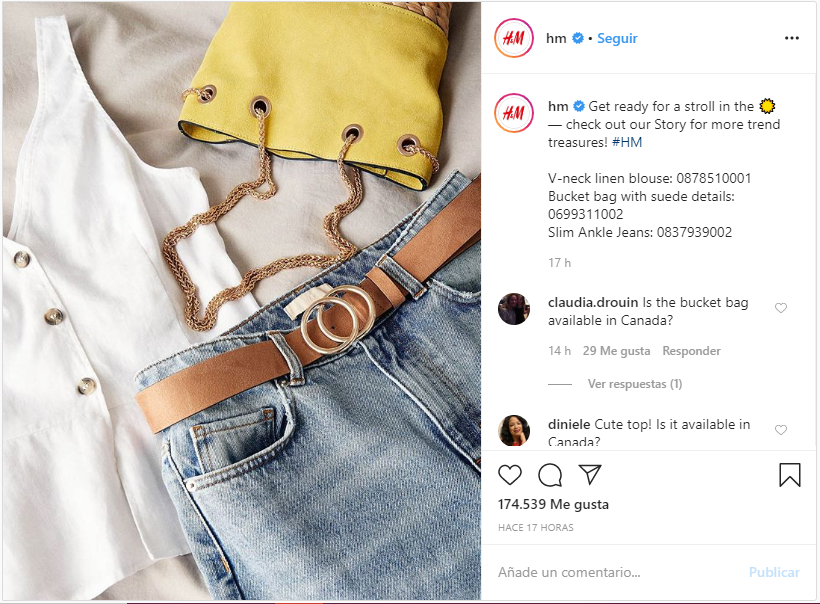


Probabilidad de la publicidad con respecto al modelo 1: 0.991454115984245
Probabilidad de la publicidad con respecto al modelo 2: 0.6466697797176835
Probabilidad de la publicidad con respecto al modelo 3: 0.99737334
-------------------------------------------------------------------------------------------------------
Probabilidad final de la publicidad: 0.8983221027411886
Clasificación: PUBLICIDAD POPULAR
-------------------------------------------------------------------------------------------------------
Get ready for a stroll in the ☀️ — check out our Story for more trend treasures! #HM V-neck linen blouse: 0878510001 Bucket bag with suede details: 0699311002 Slim Ankle Jeans: 0837939002


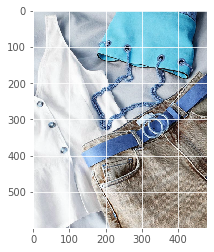

In [92]:
#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 1------------------
#-------------------------------------------
#-------------------------------------------
sent = ["Get ready for a stroll in the ☀️ — check out our Story for more trend treasures! #HM V-neck linen blouse: 0878510001 Bucket bag with suede details: 0699311002 Slim Ankle Jeans: 0837939002"]
#-------------------------------------------
## create pandas DF
text = pd.DataFrame({"txt":sent})
#-------------------------------------------
## clean the text
text["txt_clean"] = text["txt"].apply(preprocess)
#-------------------------------------------
## apply the TF-IDF object
#text_tf_idf = model_tfidf.transform(text_df["txt_clean"].values.astype('U'))
text_tfidf = model_tfidf.transform(text["txt_clean"])
tfidf_features = text_tfidf.toarray()
features_names = model_tfidf.get_feature_names()
tabla_tfidf_vector = display_features(tfidf_features,features_names)
tabla_tfidf_vector
#-------------------------------------------
## apply the TF-IDF object
predictions_text =clasificador_text.predict(tabla_tfidf_vector)
"""print("Clasificación de la publicidad con respecto al modelo 1:")
print(predictions_text)
print(" ")"""
probabilidad_text = clasificador_text.predict_proba(tabla_tfidf_vector)[:,1]
print("Probabilidad de la publicidad con respecto al modelo 1:", str(probabilidad_text[0]))

#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 2------------------
#-------------------------------------------
#-------------------------------------------
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
directorio
#-------------------------------------------
#Proceamiento de imagen
carpeta_fotos = "IMAGEN PILOTO"
imagen_nom = "publicacion_1.jpg"
ruta_archivo_img = os.path.join(directorio,carpeta_fotos,imagen_nom)
image=Procesamiento_Img(ruta_archivo_img)
#-------------------------------------------
#Extracción de caracteristicas
k, d = Sift_Vector(image)
#-------------------------------------------
#Agrupación con Kmeans de 50
tabla_sift_vector = vector_KMeans(mod_km50, d)
tabla_sift_vector
#-------------------------------------------
#Escalacion del vector
tabla_sift_vector_scal = pd.DataFrame(mod_scal.transform(tabla_sift_vector))
tabla_sift_vector_scal
#-------------------------------------------
#Predicción y clasificación
predictions_img =clasificador_img.predict(tabla_sift_vector_scal)
"""print("Clasificación de la publicidad con respecto al modelo 2:")
print(predictions_img)
print(" ")"""
probabilidad_img = clasificador_img.predict_proba(tabla_sift_vector_scal)[:,1]
print("Probabilidad de la publicidad con respecto al modelo 2:", str(probabilidad_img[0]))
#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 3------------------
#-------------------------------------------
#-------------------------------------------
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
carpeta_fotos = "IMAGEN PILOTO"
imagen_nom = "publicacion_1.jpg"
ruta_archivo_img = os.path.join(directorio,carpeta_fotos,imagen_nom)
image=Procesamiento_Img_CNN(ruta_archivo_img)
#
#Predicción y clasificación con el modelo 3
#clasificador_CNN.summary()
probabilidad_img_CNN =clasificador_CNN.predict(image)
if probabilidad_img_CNN >= 0.5:
  predictions_img_CNN =1.0
else:
  predictions_img_CNN =0.0

"""print("Clasificación de la publicidad:")
print(predictions_img_CNN)
print(" ")"""

print("Probabilidad de la publicidad con respecto al modelo 3:", str(probabilidad_img_CNN[0][0]))

#-------------------------------------------
#-------------------------------------------
#-----------------PROTOTIPO FINAL ----------
#-------------------------------------------
#-------------------------------------------
print("-------------------------------------------------------------------------------------------------------")
acc_mod1=0.89
acc_mod2=0.66
acc_mod3=0.84
prob_mod1=probabilidad_text[0]
prob_mod2=probabilidad_img[0]
prob_mod3=probabilidad_img_CNN[0][0]
probabilidad_publicidad_prototipo_final = (((acc_mod1*prob_mod1)+(acc_mod2*prob_mod2)+(acc_mod3*prob_mod3))/(acc_mod1+acc_mod2+acc_mod3))
print("Probabilidad final de la publicidad:", str(probabilidad_publicidad_prototipo_final))
if probabilidad_publicidad_prototipo_final >= 0.5:
  print("Clasificación: PUBLICIDAD POPULAR")
else:
  print("Clasificación: PUBLICIDAD NO POPULAR")
print("-------------------------------------------------------------------------------------------------------")
print(str(sent[0]))


#### Publicación 2: popular
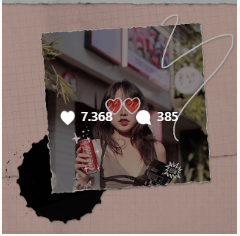
---
https://www.instagram.com/p/B7ot_tBJyWq/?utm_source=ig_web_button_share_sheet
---
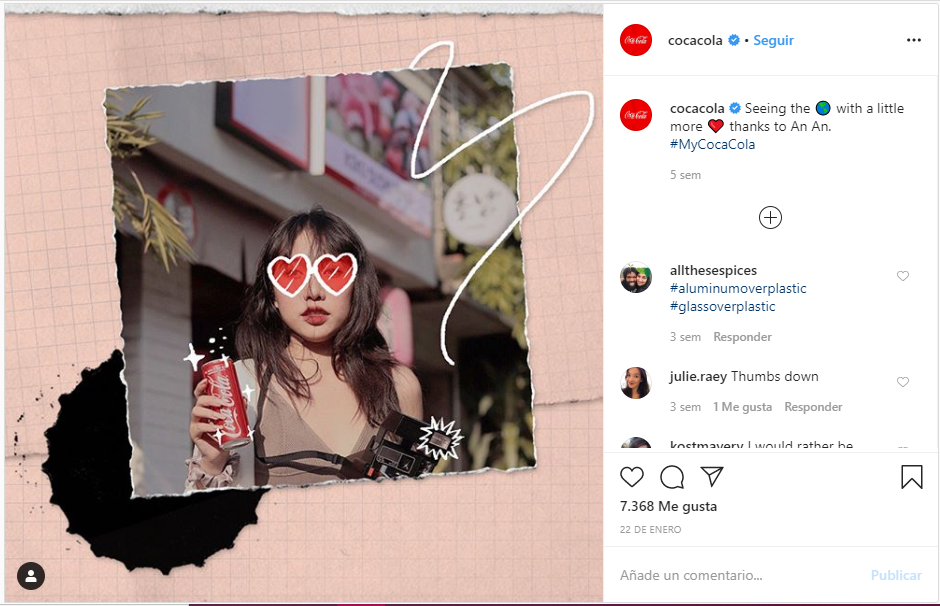



Probabilidad de la publicidad con respecto al modelo 1: 0.40782620340105624
Probabilidad de la publicidad con respecto al modelo 2: 0.8075649464561607
Probabilidad de la publicidad con respecto al modelo 3: 0.82429874
-------------------------------------------------------------------------------------------------------
Probabilidad final de la publicidad: 0.6645895928083551
Clasificación: PUBLICIDAD POPULAR
-------------------------------------------------------------------------------------------------------
Seeing the 🌎 with a little more ❤️ thanks to An An. #MyCocaCola


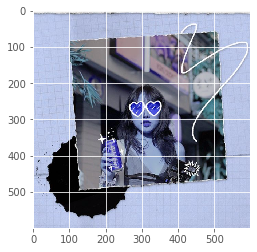

In [93]:
#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 1------------------
#-------------------------------------------
#-------------------------------------------
sent = ["Seeing the 🌎 with a little more ❤️ thanks to An An. #MyCocaCola"]
#-------------------------------------------
## create pandas DF
text = pd.DataFrame({"txt":sent})
#-------------------------------------------
## clean the text
text["txt_clean"] = text["txt"].apply(preprocess)
#print(text)
#-------------------------------------------
## apply the TF-IDF object
#text_tf_idf = model_tfidf.transform(text_df["txt_clean"].values.astype('U'))
text_tfidf = model_tfidf.transform(text["txt_clean"])
tfidf_features = text_tfidf.toarray()
features_names = model_tfidf.get_feature_names()
tabla_tfidf_vector = display_features(tfidf_features,features_names)
tabla_tfidf_vector
#-------------------------------------------
## apply the TF-IDF object
predictions_text =clasificador_text.predict(tabla_tfidf_vector)
"""print("Clasificación de la publicidad con respecto al modelo 1:")
print(predictions_text)
print(" ")"""
probabilidad_text = clasificador_text.predict_proba(tabla_tfidf_vector)[:,1]
print("Probabilidad de la publicidad con respecto al modelo 1:", str(probabilidad_text[0]))

#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 2------------------
#-------------------------------------------
#-------------------------------------------
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
directorio
#-------------------------------------------
#Proceamiento de imagen
carpeta_fotos = "IMAGEN PILOTO"
imagen_nom = "publicacion_2.jpg"
ruta_archivo_img = os.path.join(directorio,carpeta_fotos,imagen_nom)
image=Procesamiento_Img(ruta_archivo_img)
#-------------------------------------------
#Extracción de caracteristicas
k, d = Sift_Vector(image)
#-------------------------------------------
#Agrupación con Kmeans de 50
tabla_sift_vector = vector_KMeans(mod_km50, d)
tabla_sift_vector
#-------------------------------------------
#Escalacion del vector
tabla_sift_vector_scal = pd.DataFrame(mod_scal.transform(tabla_sift_vector))
tabla_sift_vector_scal
#-------------------------------------------
#Predicción y clasificación
predictions_img =clasificador_img.predict(tabla_sift_vector_scal)
"""print("Clasificación de la publicidad con respecto al modelo 2:")
print(predictions_img)
print(" ")"""
probabilidad_img = clasificador_img.predict_proba(tabla_sift_vector_scal)[:,1]
print("Probabilidad de la publicidad con respecto al modelo 2:", str(probabilidad_img[0]))
#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 3------------------
#-------------------------------------------
#-------------------------------------------
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
carpeta_fotos = "IMAGEN PILOTO"
imagen_nom = "publicacion_2.jpg"
ruta_archivo_img = os.path.join(directorio,carpeta_fotos,imagen_nom)
image=Procesamiento_Img_CNN(ruta_archivo_img)
#
#Predicción y clasificación con el modelo 3
#clasificador_CNN.summary()
probabilidad_img_CNN =clasificador_CNN.predict(image)
if probabilidad_img_CNN >= 0.5:
  predictions_img_CNN =1.0
else:
  predictions_img_CNN =0.0

"""print("Clasificación de la publicidad:")
print(predictions_img_CNN)
print(" ")"""

print("Probabilidad de la publicidad con respecto al modelo 3:", str(probabilidad_img_CNN[0][0]))

#-------------------------------------------
#-------------------------------------------
#-----------------PROTOTIPO FINAL ----------
#-------------------------------------------
#-------------------------------------------
print("-------------------------------------------------------------------------------------------------------")
acc_mod1=0.89
acc_mod2=0.66
acc_mod3=0.84
prob_mod1=probabilidad_text[0]
prob_mod2=probabilidad_img[0]
prob_mod3=probabilidad_img_CNN[0][0]
probabilidad_publicidad_prototipo_final = (((acc_mod1*prob_mod1)+(acc_mod2*prob_mod2)+(acc_mod3*prob_mod3))/(acc_mod1+acc_mod2+acc_mod3))
print("Probabilidad final de la publicidad:", str(probabilidad_publicidad_prototipo_final))
if probabilidad_publicidad_prototipo_final >= 0.5:
  print("Clasificación: PUBLICIDAD POPULAR")
else:
  print("Clasificación: PUBLICIDAD NO POPULAR")
print("-------------------------------------------------------------------------------------------------------")
print(str(sent[0]))


#### Publicación 3: popular
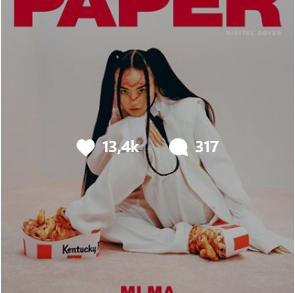
---
https://www.instagram.com/p/B8evndQpgrE/?utm_source=ig_web_copy_link
---
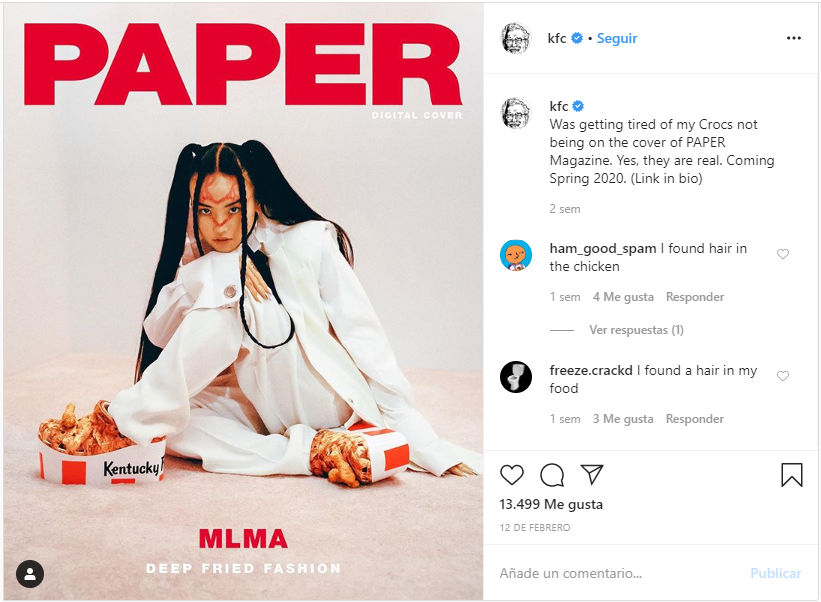

Probabilidad de la publicidad con respecto al modelo 1: 0.8849197299394082
Probabilidad de la publicidad con respecto al modelo 2: 0.6790245229843742
Probabilidad de la publicidad con respecto al modelo 3: 0.6549993
-------------------------------------------------------------------------------------------------------
Probabilidad final de la publicidad: 0.7472527908101463
Clasificación: PUBLICIDAD POPULAR
-------------------------------------------------------------------------------------------------------
Was getting tired of my Crocs not being on the cover of PAPER Magazine. Yes, they are real. Coming Spring 2020. (Link in bio)


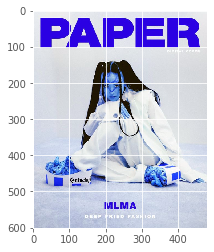

In [98]:
#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 1------------------
#-------------------------------------------
#-------------------------------------------
sent = ["Was getting tired of my Crocs not being on the cover of PAPER Magazine. Yes, they are real. Coming Spring 2020. (Link in bio)"]
#-------------------------------------------
## create pandas DF
text = pd.DataFrame({"txt":sent})
#-------------------------------------------
## clean the text
text["txt_clean"] = text["txt"].apply(preprocess)
#-------------------------------------------
## apply the TF-IDF object
#text_tf_idf = model_tfidf.transform(text_df["txt_clean"].values.astype('U'))
text_tfidf = model_tfidf.transform(text["txt_clean"])
tfidf_features = text_tfidf.toarray()
features_names = model_tfidf.get_feature_names()
tabla_tfidf_vector = display_features(tfidf_features,features_names)
tabla_tfidf_vector
#-------------------------------------------
## apply the TF-IDF object
predictions_text =clasificador_text.predict(tabla_tfidf_vector)
"""print("Clasificación de la publicidad con respecto al modelo 1:")
print(predictions_text)
print(" ")"""
probabilidad_text = clasificador_text.predict_proba(tabla_tfidf_vector)[:,1]
print("Probabilidad de la publicidad con respecto al modelo 1:", str(probabilidad_text[0]))

#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 2------------------
#-------------------------------------------
#-------------------------------------------
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
directorio
#-------------------------------------------
#Proceamiento de imagen
carpeta_fotos = "IMAGEN PILOTO"
imagen_nom = "publicacion_3.jpg"
ruta_archivo_img = os.path.join(directorio,carpeta_fotos,imagen_nom)
image=Procesamiento_Img(ruta_archivo_img)
#-------------------------------------------
#Extracción de caracteristicas
k, d = Sift_Vector(image)
#-------------------------------------------
#Agrupación con Kmeans de 50
tabla_sift_vector = vector_KMeans(mod_km50, d)
tabla_sift_vector
#-------------------------------------------
#Escalacion del vector
tabla_sift_vector_scal = pd.DataFrame(mod_scal.transform(tabla_sift_vector))
tabla_sift_vector_scal
#-------------------------------------------
#Predicción y clasificación
predictions_img =clasificador_img.predict(tabla_sift_vector_scal)
"""print("Clasificación de la publicidad con respecto al modelo 2:")
print(predictions_img)
print(" ")"""
probabilidad_img = clasificador_img.predict_proba(tabla_sift_vector_scal)[:,1]
print("Probabilidad de la publicidad con respecto al modelo 2:", str(probabilidad_img[0]))
#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 3------------------
#-------------------------------------------
#-------------------------------------------
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
carpeta_fotos = "IMAGEN PILOTO"
imagen_nom = "publicacion_3.jpg"
ruta_archivo_img = os.path.join(directorio,carpeta_fotos,imagen_nom)
image=Procesamiento_Img_CNN(ruta_archivo_img)
#
#Predicción y clasificación con el modelo 3
#clasificador_CNN.summary()
probabilidad_img_CNN =clasificador_CNN.predict(image)
if probabilidad_img_CNN >= 0.5:
  predictions_img_CNN =1.0
else:
  predictions_img_CNN =0.0

"""print("Clasificación de la publicidad:")
print(predictions_img_CNN)
print(" ")"""

print("Probabilidad de la publicidad con respecto al modelo 3:", str(probabilidad_img_CNN[0][0]))

#-------------------------------------------
#-------------------------------------------
#-----------------PROTOTIPO FINAL ----------
#-------------------------------------------
#-------------------------------------------
print("-------------------------------------------------------------------------------------------------------")
acc_mod1=0.89
acc_mod2=0.66
acc_mod3=0.84
prob_mod1=probabilidad_text[0]
prob_mod2=probabilidad_img[0]
prob_mod3=probabilidad_img_CNN[0][0]
probabilidad_publicidad_prototipo_final = (((acc_mod1*prob_mod1)+(acc_mod2*prob_mod2)+(acc_mod3*prob_mod3))/(acc_mod1+acc_mod2+acc_mod3))
print("Probabilidad final de la publicidad:", str(probabilidad_publicidad_prototipo_final))
if probabilidad_publicidad_prototipo_final >= 0.5:
  print("Clasificación: PUBLICIDAD POPULAR")
else:
  print("Clasificación: PUBLICIDAD NO POPULAR")
print("-------------------------------------------------------------------------------------------------------")
print(str(sent[0]))


#### Publicación 4: no popular
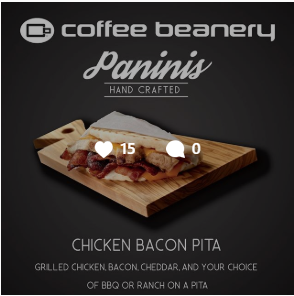
---
https://www.instagram.com/p/B9HWz5ul1M4/?utm_source=ig_web_copy_link
---
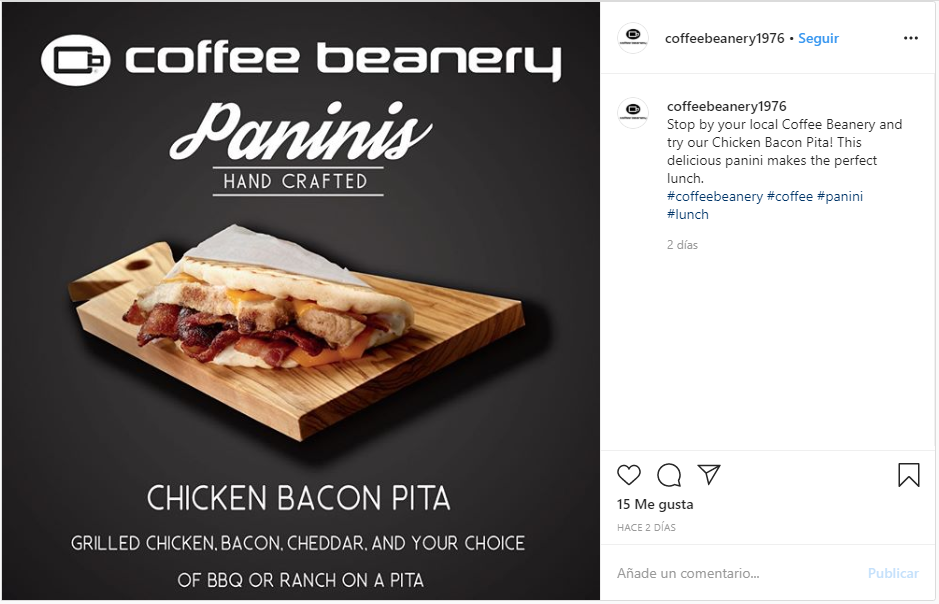


Probabilidad de la publicidad con respecto al modelo 1: 0.03163418913467941
Probabilidad de la publicidad con respecto al modelo 2: 0.39103553968862204
Probabilidad de la publicidad con respecto al modelo 3: 0.0067089326
-------------------------------------------------------------------------------------------------------
Probabilidad final de la publicidad: 0.12212275643816717
Clasificación: PUBLICIDAD NO POPULAR
-------------------------------------------------------------------------------------------------------
Stop by your local Coffee Beanery and try our Chicken Bacon Pita! This delicious panini makes the perfect lunch. #coffeebeanery #coffee #panini #lunch


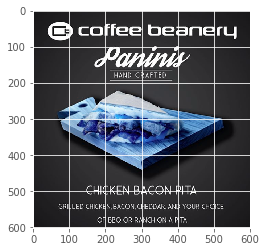

In [102]:
#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 1------------------
#-------------------------------------------
#-------------------------------------------
sent = ["Stop by your local Coffee Beanery and try our Chicken Bacon Pita! This delicious panini makes the perfect lunch. #coffeebeanery #coffee #panini #lunch"]
#-------------------------------------------
## create pandas DF
text = pd.DataFrame({"txt":sent})
#-------------------------------------------
## clean the text
text["txt_clean"] = text["txt"].apply(preprocess)
#-------------------------------------------
## apply the TF-IDF object
#text_tf_idf = model_tfidf.transform(text_df["txt_clean"].values.astype('U'))
text_tfidf = model_tfidf.transform(text["txt_clean"])
tfidf_features = text_tfidf.toarray()
features_names = model_tfidf.get_feature_names()
tabla_tfidf_vector = display_features(tfidf_features,features_names)
tabla_tfidf_vector
#-------------------------------------------
## apply the TF-IDF object
predictions_text =clasificador_text.predict(tabla_tfidf_vector)
"""print("Clasificación de la publicidad con respecto al modelo 1:")
print(predictions_text)
print(" ")"""
probabilidad_text = clasificador_text.predict_proba(tabla_tfidf_vector)[:,1]
print("Probabilidad de la publicidad con respecto al modelo 1:", str(probabilidad_text[0]))

#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 2------------------
#-------------------------------------------
#-------------------------------------------
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
directorio
#-------------------------------------------
#Proceamiento de imagen
carpeta_fotos = "IMAGEN PILOTO"
imagen_nom = "publicacion_4.jpg"
ruta_archivo_img = os.path.join(directorio,carpeta_fotos,imagen_nom)
image=Procesamiento_Img(ruta_archivo_img)
#-------------------------------------------
#Extracción de caracteristicas
k, d = Sift_Vector(image)
#-------------------------------------------
#Agrupación con Kmeans de 50
tabla_sift_vector = vector_KMeans(mod_km50, d)
tabla_sift_vector
#-------------------------------------------
#Escalacion del vector
tabla_sift_vector_scal = pd.DataFrame(mod_scal.transform(tabla_sift_vector))
tabla_sift_vector_scal
#-------------------------------------------
#Predicción y clasificación
predictions_img =clasificador_img.predict(tabla_sift_vector_scal)
"""print("Clasificación de la publicidad con respecto al modelo 2:")
print(predictions_img)
print(" ")"""
probabilidad_img = clasificador_img.predict_proba(tabla_sift_vector_scal)[:,1]
print("Probabilidad de la publicidad con respecto al modelo 2:", str(probabilidad_img[0]))
#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 3------------------
#-------------------------------------------
#-------------------------------------------
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
carpeta_fotos = "IMAGEN PILOTO"
imagen_nom = "publicacion_4.jpg"
ruta_archivo_img = os.path.join(directorio,carpeta_fotos,imagen_nom)
image=Procesamiento_Img_CNN(ruta_archivo_img)
#
#Predicción y clasificación con el modelo 3
#clasificador_CNN.summary()
probabilidad_img_CNN =clasificador_CNN.predict(image)
if probabilidad_img_CNN >= 0.5:
  predictions_img_CNN =1.0
else:
  predictions_img_CNN =0.0

"""print("Clasificación de la publicidad:")
print(predictions_img_CNN)
print(" ")"""

print("Probabilidad de la publicidad con respecto al modelo 3:", str(probabilidad_img_CNN[0][0]))

#-------------------------------------------
#-------------------------------------------
#-----------------PROTOTIPO FINAL ----------
#-------------------------------------------
#-------------------------------------------
print("-------------------------------------------------------------------------------------------------------")
acc_mod1=0.89
acc_mod2=0.66
acc_mod3=0.84
prob_mod1=probabilidad_text[0]
prob_mod2=probabilidad_img[0]
prob_mod3=probabilidad_img_CNN[0][0]
probabilidad_publicidad_prototipo_final = (((acc_mod1*prob_mod1)+(acc_mod2*prob_mod2)+(acc_mod3*prob_mod3))/(acc_mod1+acc_mod2+acc_mod3))
print("Probabilidad final de la publicidad:", str(probabilidad_publicidad_prototipo_final))
if probabilidad_publicidad_prototipo_final >= 0.5:
  print("Clasificación: PUBLICIDAD POPULAR")
else:
  print("Clasificación: PUBLICIDAD NO POPULAR")
print("-------------------------------------------------------------------------------------------------------")
print(str(sent[0]))


#### Publicación 5: no popular
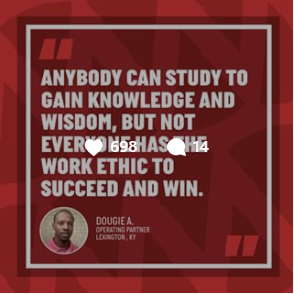
---
https://www.instagram.com/p/B9HcCx6FFbQ/?utm_source=ig_web_copy_link
---
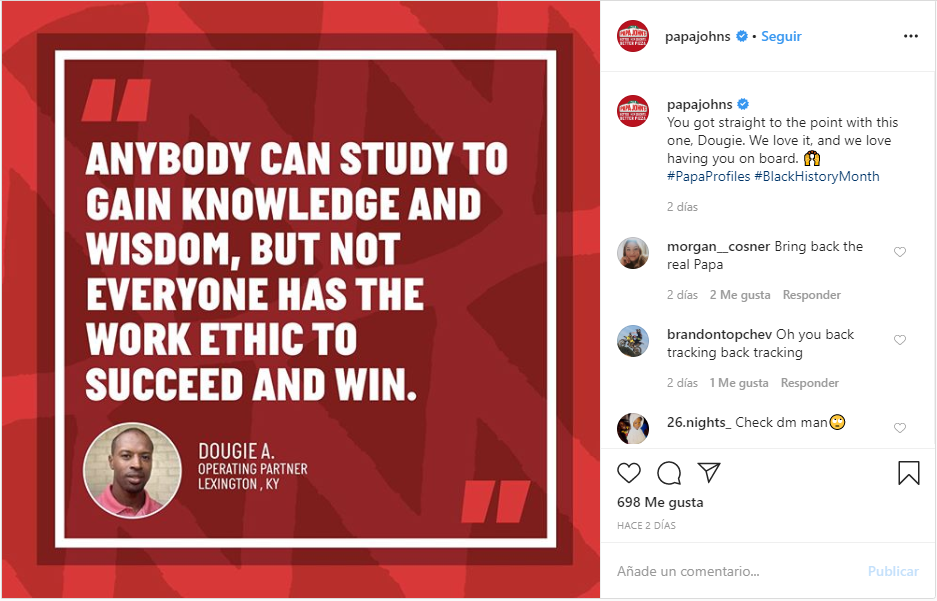


Probabilidad de la publicidad con respecto al modelo 1: 0.50966138659026
Probabilidad de la publicidad con respecto al modelo 2: 0.5652892099891281
Probabilidad de la publicidad con respecto al modelo 3: 0.044932455
-------------------------------------------------------------------------------------------------------
Probabilidad final de la publicidad: 0.3616873534354359
Clasificación: PUBLICIDAD NO POPULAR
-------------------------------------------------------------------------------------------------------
You got straight to the point with this one, Dougie. We love it, and we love having you on board. 🙌 #PapaProfiles #BlackHistoryMonth


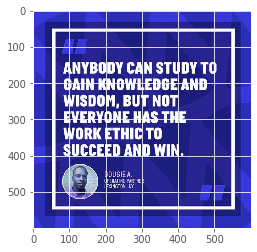

In [104]:
#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 1------------------
#-------------------------------------------
#-------------------------------------------
sent = ["You got straight to the point with this one, Dougie. We love it, and we love having you on board. 🙌 #PapaProfiles #BlackHistoryMonth"]
#-------------------------------------------
## create pandas DF
text = pd.DataFrame({"txt":sent})
#-------------------------------------------
## clean the text
text["txt_clean"] = text["txt"].apply(preprocess)
#-------------------------------------------
## apply the TF-IDF object
#text_tf_idf = model_tfidf.transform(text_df["txt_clean"].values.astype('U'))
text_tfidf = model_tfidf.transform(text["txt_clean"])
tfidf_features = text_tfidf.toarray()
features_names = model_tfidf.get_feature_names()
tabla_tfidf_vector = display_features(tfidf_features,features_names)
tabla_tfidf_vector
#-------------------------------------------
## apply the TF-IDF object
predictions_text =clasificador_text.predict(tabla_tfidf_vector)
"""print("Clasificación de la publicidad con respecto al modelo 1:")
print(predictions_text)
print(" ")"""
probabilidad_text = clasificador_text.predict_proba(tabla_tfidf_vector)[:,1]
print("Probabilidad de la publicidad con respecto al modelo 1:", str(probabilidad_text[0]))

#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 2------------------
#-------------------------------------------
#-------------------------------------------
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
directorio
#-------------------------------------------
#Proceamiento de imagen
carpeta_fotos = "IMAGEN PILOTO"
imagen_nom = "publicacion_5.jpg"
ruta_archivo_img = os.path.join(directorio,carpeta_fotos,imagen_nom)
image=Procesamiento_Img(ruta_archivo_img)
#-------------------------------------------
#Extracción de caracteristicas
k, d = Sift_Vector(image)
#-------------------------------------------
#Agrupación con Kmeans de 50
tabla_sift_vector = vector_KMeans(mod_km50, d)
tabla_sift_vector
#-------------------------------------------
#Escalacion del vector
tabla_sift_vector_scal = pd.DataFrame(mod_scal.transform(tabla_sift_vector))
tabla_sift_vector_scal
#-------------------------------------------
#Predicción y clasificación
predictions_img =clasificador_img.predict(tabla_sift_vector_scal)
"""print("Clasificación de la publicidad con respecto al modelo 2:")
print(predictions_img)
print(" ")"""
probabilidad_img = clasificador_img.predict_proba(tabla_sift_vector_scal)[:,1]
print("Probabilidad de la publicidad con respecto al modelo 2:", str(probabilidad_img[0]))
#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 3------------------
#-------------------------------------------
#-------------------------------------------
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
carpeta_fotos = "IMAGEN PILOTO"
imagen_nom = "publicacion_5.jpg"
ruta_archivo_img = os.path.join(directorio,carpeta_fotos,imagen_nom)
image=Procesamiento_Img_CNN(ruta_archivo_img)
#
#Predicción y clasificación con el modelo 3
#clasificador_CNN.summary()
probabilidad_img_CNN =clasificador_CNN.predict(image)
if probabilidad_img_CNN >= 0.5:
  predictions_img_CNN =1.0
else:
  predictions_img_CNN =0.0

"""print("Clasificación de la publicidad:")
print(predictions_img_CNN)
print(" ")"""

print("Probabilidad de la publicidad con respecto al modelo 3:", str(probabilidad_img_CNN[0][0]))

#-------------------------------------------
#-------------------------------------------
#-----------------PROTOTIPO FINAL ----------
#-------------------------------------------
#-------------------------------------------
print("-------------------------------------------------------------------------------------------------------")
acc_mod1=0.89
acc_mod2=0.66
acc_mod3=0.84
prob_mod1=probabilidad_text[0]
prob_mod2=probabilidad_img[0]
prob_mod3=probabilidad_img_CNN[0][0]
probabilidad_publicidad_prototipo_final = (((acc_mod1*prob_mod1)+(acc_mod2*prob_mod2)+(acc_mod3*prob_mod3))/(acc_mod1+acc_mod2+acc_mod3))
print("Probabilidad final de la publicidad:", str(probabilidad_publicidad_prototipo_final))
if probabilidad_publicidad_prototipo_final >= 0.5:
  print("Clasificación: PUBLICIDAD POPULAR")
else:
  print("Clasificación: PUBLICIDAD NO POPULAR")
print("-------------------------------------------------------------------------------------------------------")
print(str(sent[0]))


#### Publicación 6: no popular
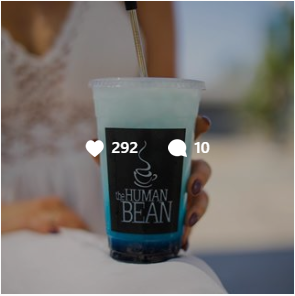
---
https://www.instagram.com/p/B9HylOXJMIs/?utm_source=ig_web_copy_link
---
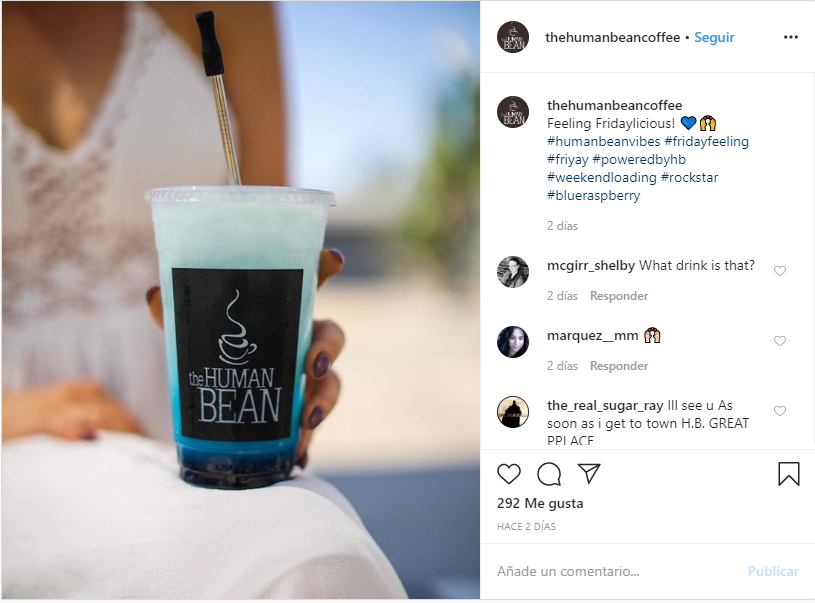

Probabilidad de la publicidad con respecto al modelo 1: 0.031163596334707003
Probabilidad de la publicidad con respecto al modelo 2: 0.5
Probabilidad de la publicidad con respecto al modelo 3: 0.0
-------------------------------------------------------------------------------------------------------
Probabilidad final de la publicidad: 0.149680167672757
Clasificación: PUBLICIDAD NO POPULAR
-------------------------------------------------------------------------------------------------------
Feeling Fridaylicious! 💙🙌 #humanbeanvibes #fridayfeeling #friyay #poweredbyhb #weekendloading #rockstar #blueraspberry


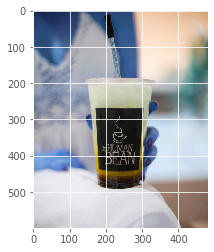

In [105]:
#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 1------------------
#-------------------------------------------
#-------------------------------------------
sent = ["Feeling Fridaylicious! 💙🙌 #humanbeanvibes #fridayfeeling #friyay #poweredbyhb #weekendloading #rockstar #blueraspberry"]
#-------------------------------------------
## create pandas DF
text = pd.DataFrame({"txt":sent})
#-------------------------------------------
## clean the text
text["txt_clean"] = text["txt"].apply(preprocess)
#-------------------------------------------
## apply the TF-IDF object
#text_tf_idf = model_tfidf.transform(text_df["txt_clean"].values.astype('U'))
text_tfidf = model_tfidf.transform(text["txt_clean"])
tfidf_features = text_tfidf.toarray()
features_names = model_tfidf.get_feature_names()
tabla_tfidf_vector = display_features(tfidf_features,features_names)
tabla_tfidf_vector
#-------------------------------------------
## apply the TF-IDF object
predictions_text =clasificador_text.predict(tabla_tfidf_vector)
"""print("Clasificación de la publicidad con respecto al modelo 1:")
print(predictions_text)
print(" ")"""
probabilidad_text = clasificador_text.predict_proba(tabla_tfidf_vector)[:,1]
print("Probabilidad de la publicidad con respecto al modelo 1:", str(probabilidad_text[0]))

#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 2------------------
#-------------------------------------------
#-------------------------------------------
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
directorio
#-------------------------------------------
#Proceamiento de imagen
carpeta_fotos = "IMAGEN PILOTO"
imagen_nom = "publicacion_6.jpg"
ruta_archivo_img = os.path.join(directorio,carpeta_fotos,imagen_nom)
image = Procesamiento_Img(ruta_archivo_img)
#-------------------------------------------
#Extracción de caracteristicas
k, d = Sift_Vector(image)
#-------------------------------------------
#Agrupación con Kmeans de 50
tabla_sift_vector = vector_KMeans(mod_km50, d)
tabla_sift_vector
#-------------------------------------------
#Escalacion del vector
tabla_sift_vector_scal = pd.DataFrame(mod_scal.transform(tabla_sift_vector))
tabla_sift_vector_scal
#-------------------------------------------
#Predicción y clasificación
predictions_img =clasificador_img.predict(tabla_sift_vector_scal)
"""print("Clasificación de la publicidad con respecto al modelo 2:")
print(predictions_img)
print(" ")"""
probabilidad_img = clasificador_img.predict_proba(tabla_sift_vector_scal)[:,1]
print("Probabilidad de la publicidad con respecto al modelo 2:", str(probabilidad_img[0]))
#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 3------------------
#-------------------------------------------
#-------------------------------------------
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
carpeta_fotos = "IMAGEN PILOTO"
imagen_nom = "publicacion_6.jpg"
ruta_archivo_img = os.path.join(directorio,carpeta_fotos,imagen_nom)
image=Procesamiento_Img_CNN(ruta_archivo_img)
#
#Predicción y clasificación con el modelo 3
#clasificador_CNN.summary()
probabilidad_img_CNN =clasificador_CNN.predict(image)
if probabilidad_img_CNN >= 0.5:
  predictions_img_CNN =1.0
else:
  predictions_img_CNN =0.0

"""print("Clasificación de la publicidad:")
print(predictions_img_CNN)
print(" ")"""

print("Probabilidad de la publicidad con respecto al modelo 3:", str(probabilidad_img_CNN[0][0]))

#-------------------------------------------
#-------------------------------------------
#-----------------PROTOTIPO FINAL ----------
#-------------------------------------------
#-------------------------------------------
print("-------------------------------------------------------------------------------------------------------")
acc_mod1=0.89
acc_mod2=0.66
acc_mod3=0.84
prob_mod1=probabilidad_text[0]
prob_mod2=probabilidad_img[0]
prob_mod3=probabilidad_img_CNN[0][0]
probabilidad_publicidad_prototipo_final = (((acc_mod1*prob_mod1)+(acc_mod2*prob_mod2)+(acc_mod3*prob_mod3))/(acc_mod1+acc_mod2+acc_mod3))
print("Probabilidad final de la publicidad:", str(probabilidad_publicidad_prototipo_final))
if probabilidad_publicidad_prototipo_final >= 0.5:
  print("Clasificación: PUBLICIDAD POPULAR")
else:
  print("Clasificación: PUBLICIDAD NO POPULAR")
print("-------------------------------------------------------------------------------------------------------")
print(str(sent[0]))


#### Publicación del doc: popular

Probabilidad de la publicidad con respecto al modelo 1: 0.9873480225388718
Probabilidad de la publicidad con respecto al modelo 2: 0.5949956388342188
Probabilidad de la publicidad con respecto al modelo 3: 0.994364
-------------------------------------------------------------------------------------------------------
Probabilidad final de la publicidad: 0.8814655402449454
Clasificación: PUBLICIDAD POPULAR
-------------------------------------------------------------------------------------------------------
a flame-grilled Whopper is just what Harley Quinn needs to get over her ex-flame. amirite? #burgerquinn 


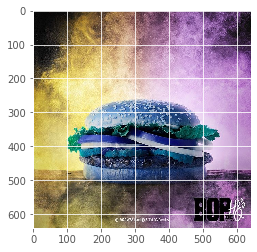

In [0]:
#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 1------------------
#-------------------------------------------
#-------------------------------------------
sent = ["a flame-grilled Whopper is just what Harley Quinn needs to get over her ex-flame. amirite? #burgerquinn "]
#-------------------------------------------
## create pandas DF
text = pd.DataFrame({"txt":sent})
#-------------------------------------------
## clean the text
text["txt_clean"] = text["txt"].apply(preprocess)
#-------------------------------------------
## apply the TF-IDF object
#text_tf_idf = model_tfidf.transform(text_df["txt_clean"].values.astype('U'))
text_tfidf = model_tfidf.transform(text["txt_clean"])
tfidf_features = text_tfidf.toarray()
features_names = model_tfidf.get_feature_names()
tabla_tfidf_vector = display_features(tfidf_features,features_names)
tabla_tfidf_vector
#-------------------------------------------
## apply the TF-IDF object
predictions_text =clasificador_text.predict(tabla_tfidf_vector)
"""print("Clasificación de la publicidad con respecto al modelo 1:")
print(predictions_text)
print(" ")"""
probabilidad_text = clasificador_text.predict_proba(tabla_tfidf_vector)[:,1]
print("Probabilidad de la publicidad con respecto al modelo 1:", str(probabilidad_text[0]))

#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 2------------------
#-------------------------------------------
#-------------------------------------------
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
directorio
#-------------------------------------------
#Proceamiento de imagen
carpeta_fotos = "IMAGEN PILOTO"
imagen_nom = "Test.jpg"
ruta_archivo_img = os.path.join(directorio,carpeta_fotos,imagen_nom)
image=Procesamiento_Img(ruta_archivo_img)
#-------------------------------------------
#Extracción de caracteristicas
k, d = Sift_Vector(image)
#-------------------------------------------
#Agrupación con Kmeans de 50
tabla_sift_vector = vector_KMeans(mod_km50, d)
tabla_sift_vector
#-------------------------------------------
#Escalacion del vector
tabla_sift_vector_scal = pd.DataFrame(mod_scal.transform(tabla_sift_vector))
tabla_sift_vector_scal
#-------------------------------------------
#Predicción y clasificación
predictions_img =clasificador_img.predict(tabla_sift_vector_scal)
"""print("Clasificación de la publicidad con respecto al modelo 2:")
print(predictions_img)
print(" ")"""
probabilidad_img = clasificador_img.predict_proba(tabla_sift_vector_scal)[:,1]
print("Probabilidad de la publicidad con respecto al modelo 2:", str(probabilidad_img[0]))
#-------------------------------------------
#-------------------------------------------
#-----------------MODELO 3------------------
#-------------------------------------------
#-------------------------------------------
directorio = 'drive/My Drive/2019-2 #CICLO_10♥/TESIS 2/DATA/'
carpeta_fotos = "IMAGEN PILOTO"
imagen_nom = "Test.jpg"
ruta_archivo_img = os.path.join(directorio,carpeta_fotos,imagen_nom)
image=Procesamiento_Img_CNN(ruta_archivo_img)
#
#Predicción y clasificación con el modelo 3
#clasificador_CNN.summary()
probabilidad_img_CNN =clasificador_CNN.predict(image)
if probabilidad_img_CNN >= 0.5:
  predictions_img_CNN =1.0
else:
  predictions_img_CNN =0.0

"""print("Clasificación de la publicidad:")
print(predictions_img_CNN)
print(" ")"""

print("Probabilidad de la publicidad con respecto al modelo 3:", str(probabilidad_img_CNN[0][0]))

#-------------------------------------------
#-------------------------------------------
#-----------------PROTOTIPO FINAL ----------
#-------------------------------------------
#-------------------------------------------
print("-------------------------------------------------------------------------------------------------------")
acc_mod1=0.89
acc_mod2=0.66
acc_mod3=0.84
prob_mod1=probabilidad_text[0]
prob_mod2=probabilidad_img[0]
prob_mod3=probabilidad_img_CNN[0][0]
probabilidad_publicidad_prototipo_final = (((acc_mod1*prob_mod1)+(acc_mod2*prob_mod2)+(acc_mod3*prob_mod3))/(acc_mod1+acc_mod2+acc_mod3))
print("Probabilidad final de la publicidad:", str(probabilidad_publicidad_prototipo_final))
if probabilidad_publicidad_prototipo_final >= 0.5:
  print("Clasificación: PUBLICIDAD POPULAR")
else:
  print("Clasificación: PUBLICIDAD NO POPULAR")
print("-------------------------------------------------------------------------------------------------------")
print(str(sent[0]))
